In [1]:
import dask.array as da
import numpy as np

DASK arrays are intialised with the exact same syntax used in `numpy`:

In [2]:
%%time

darr = da.random.random((2000,2000,2000))

CPU times: user 14.9 ms, sys: 11.6 ms, total: 26.4 ms
Wall time: 75 ms


The initialisation, however, **does not store data into memory**. Data will be sent to the RAM only when computations on `darr` will be performed. Such computations will be **parallelised**, i.e. the array is split into "chunks", each of which is sent to an individual CPU core to perform the sought computation. The `darr` object still contains all of the information needed:

In [3]:
darr

dask.array<random_sample, shape=(2000, 2000, 2000), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

Including the size and shape of the chunks. The advantage of using `dask.array` over `numpy.ndarray` is not only that calculations on the array will be parallelised, but also that only **larger-than-memory** arrays can be used for such calculations. For example, the numpy version of the above array would occupy 64Gb of RAM. On the other hand, `darr` only needs hundreds of Mb, as only individual chunks are being sent to memory at any given time. 

Initialising `darr` took a few ms. Taking its sum along the first axis takes only a couple of seconds:

In [5]:
%%time 

darr.sum().compute()

CPU times: user 1min 14s, sys: 20.5 s, total: 1min 34s
Wall time: 7.09 s


3999953837.4619236

While the same array takes more than a minute (and 64Gb of RAM) to be initialised by `numpy`:

In [17]:
%%time

nparr = np.random.random((2000,2000,2000))

CPU times: user 57.4 s, sys: 18.2 s, total: 1min 15s
Wall time: 1min 15s


And a couple more seconds for the sum to be computed:

In [18]:
%%time

nparr.sum()

CPU times: user 5.27 s, sys: 29.5 ms, total: 5.3 s
Wall time: 5.29 s


4000042957.049623

# Practical example

To illustrate the power of `dask.array` in practice, below the spatial distribution of centres of mass (COMs) of a 5D SXDM dataset will be computed, both with `numpy` and `dask`.

## With NumPy:

In [18]:
import h5py

from h5glance import H5Glance as h5ls

The dataset of interest is contained in an `hdf5` file:

In [8]:
h5path = './ma4449/analysis/xsocs_KMAP_2020_10_04_001645_fast_00001_S1-11/qspace_noshift_0.h5'

which occupies 440 Mb on disk,

In [22]:
ls -lh {h5path}

-rw-r--r-- 1 zatterin id01 439M Nov 16 10:31 ./ma4449/analysis/xsocs_KMAP_2020_10_04_001645_fast_00001_S1-11/qspace_noshift_0.h5


because it is compressed with the `gzip` filter:

In [23]:
h5f = h5py.File(h5path, 'r')

h5f['/Data/qspace'].compression

'gzip'

This means that a major bottleneck in whatever computation to be performed will be the time needed to uncompress the data on its way to the RAM. While ways to read/write `hdf5` data in a parallel fashion [do exist](https://docs.h5py.org/en/stable/mpi.html), at the moment this is not implemented in any ESRF-generated `hdf5` file. 

So, storing the data into a `numpy` array takes quite a while:

In [24]:
%%time 

npdset = h5f['/Data/qspace'][...]

CPU times: user 39.5 s, sys: 8.47 s, total: 48 s
Wall time: 47.6 s


This `npdset` is now almost 7Gb in size:

In [25]:
import sys

sys.getsizeof(npdset) / 1e9

6.875000144

In [26]:
%whos ndarray

Variable   Type       Data/Info
-------------------------------
npdset     ndarray    15625x11x100x100: 1718750000 elems, type `float32`, 6875000000 bytes (6556.510925292969 Mb)


By loading the $Q_x, Q_y, Q_z$ coordinates of the dataset, one can calculate the COMs using only `numpy` built-in functions (so-called [universal functions](https://numpy.org/doc/stable/reference/ufuncs.html)), which are wrappers around C code and are hence rather fast:

In [27]:
qx, qy, qz = [h5f[f'/Data/{x}'][()] for x in 'qx,qy,qz'.split(',')]

qxx, qyy, qzz = np.meshgrid(qx, qy, qz, indexing='ij')

In [28]:
%%time

cx, cy, cz = [(np.sum(npdset*pos, axis=(1,2,3))/npdset.sum(axis=(1,2,3))) 
              for pos in (qxx, qyy, qzz)]

CPU times: user 11.3 s, sys: 11.9 s, total: 23.2 s
Wall time: 23.2 s


So that 23s later one can visualise the spatial distribution of the COMs away from their average value:

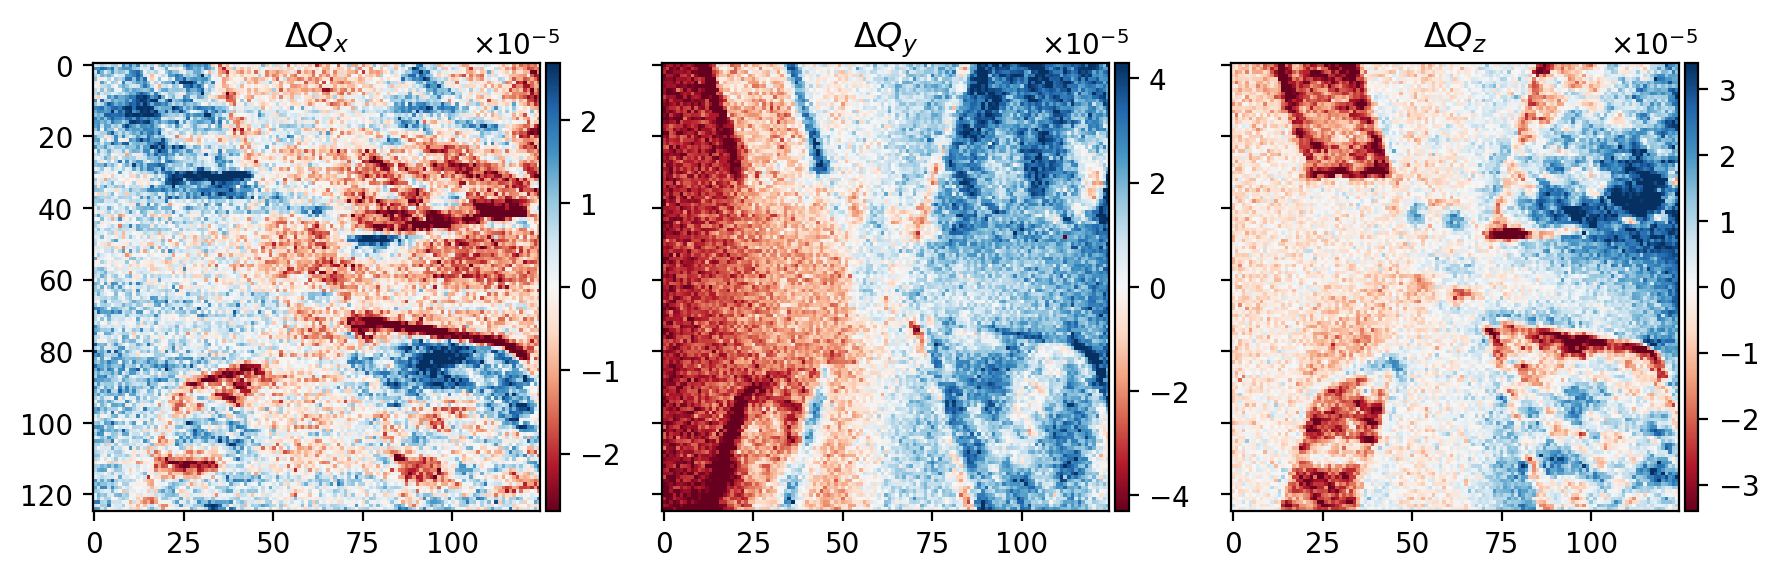

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'

kmap_sh = int(np.sqrt(cx.shape[0]))
names = [f'$\Delta Q_{x}$' for x in 'x,y,z'.split(',')]

fig, ax = plt.subplots(1,3, figsize=(9,4), dpi=100, sharey=True)

for a, c, name in zip(ax, [cx, cy, cz], names):
    
    topl = c.reshape(kmap_sh, kmap_sh)*1e3
    topl = topl - topl.mean()
    
    im = a.imshow(topl, cmap='RdBu')
    im.set_clim(-np.percentile(topl, 99), np.percentile(topl, 99))
    
    cax = make_axes_locatable(a).append_axes('right', '3%', pad=.03)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.ticklabel_format(scilimits=(0,0), useMathText=True)
    
    a.set_title(name)
    
fig.tight_layout()

## With DASK

Now the same is done by using a `dask.array`. Note below that the chunk size has been chosen so to create as many chunks as available CPU cores:

In [30]:
import os

dset_sh = h5f['/Data/qspace'].shape

dset = da.from_array(h5f['/Data/qspace'], chunks=(dset_sh[0]//os.cpu_count(), *dset_sh[1:]))

In [31]:
dset

dask.array<array, shape=(15625, 11, 100, 100), dtype=float32, chunksize=(558, 11, 100, 100), chunktype=numpy.ndarray>

Since this time the array is small enoguh to fit into memory ("only" 7Gb), and one is thus only interested in the capability of `dask.array` to perform parallel computations, `dset` can be stored into the RAM by using the `.persist()` method:

In [32]:
%%time

pdset = dset.persist()

CPU times: user 43.7 s, sys: 8.22 s, total: 51.9 s
Wall time: 51.4 s


This takes a bit longer than the equivalent operation with `numpy`, since an unnecessary level of complexity - the chunking - is now present. However, the computation of COMs is now **much** faster:

In [33]:
dqxx, dqyy, dqzz = np.meshgrid(*[da.from_array(h5f[f'/Data/{x}']) for x in 'qx,qy,qz'.split(',')], indexing='ij')

In [34]:
%%time 

dcx, dcy, dcz = [(da.sum(pdset*pos, axis=(1,2,3))/pdset.sum(axis=(1,2,3))).compute() 
              for pos in (dqxx, dqyy, dqzz)]

CPU times: user 25.7 s, sys: 16.2 s, total: 41.9 s
Wall time: 1.94 s


And the same visualisation can be carried out.

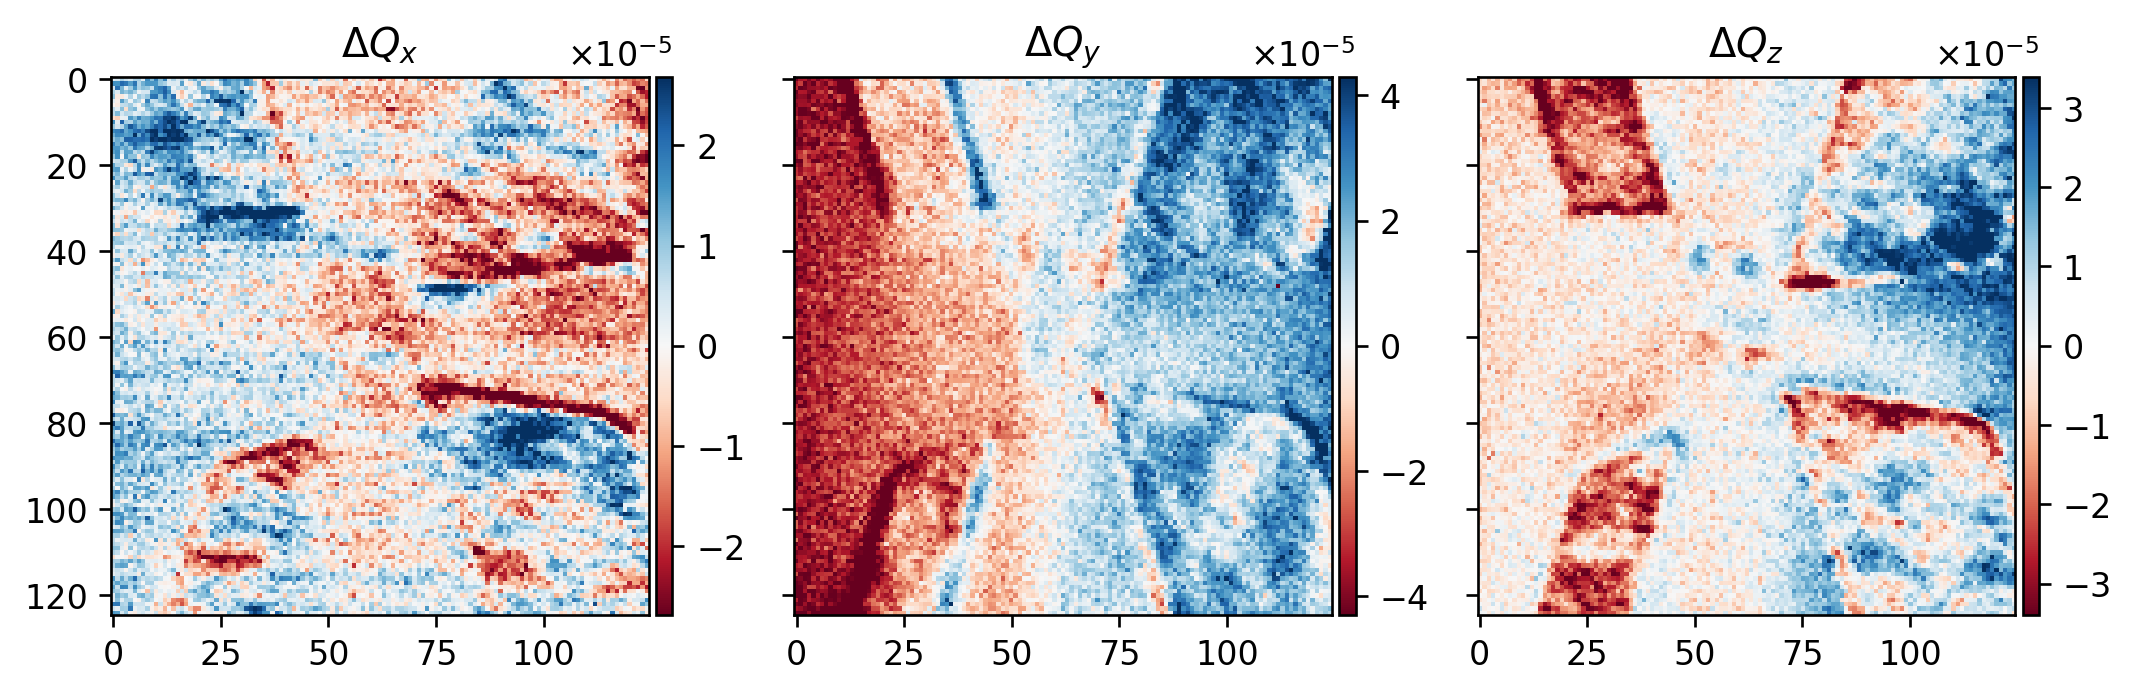

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'

kmap_sh = int(np.sqrt(cx.shape[0]))
names = [f'$\Delta Q_{x}$' for x in 'x,y,z'.split(',')]

fig, ax = plt.subplots(1,3, figsize=(9,4), dpi=120, sharey=True)

for a, c, name in zip(ax, [dcx, dcy, dcz], names):
    
    topl = c.reshape(kmap_sh, kmap_sh)*1e3
    topl = topl - topl.mean()
    
    im = a.imshow(topl, cmap='RdBu')
    im.set_clim(-np.percentile(topl, 99), np.percentile(topl, 99))
    
    cax = make_axes_locatable(a).append_axes('right', '3%', pad=.03)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.ticklabel_format(scilimits=(0,0), useMathText=True)
    
    a.set_title(name)
    
fig.tight_layout()